# Análise Preditiva de Inadimplência
---
Desafio proposto pela }`Datarisk`.<br>
__Candidata__: Laryssa Stephanie Andrade da Costa Silva | [LinkedIn](https://www.linkedin.com/in/laryssastephanie/) | [Github](https://github.com/laryssastephanie)

---

In [76]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import lightgbm as lgb
import xgboost as xgb
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklego.meta import Thresholder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, PrecisionRecallDisplay, precision_recall_curve, ConfusionMatrixDisplay, confusion_matrix

In [178]:
data_train = pd.read_csv('case_datarisk/treino.csv')
data_train.index = data_train.index + 1
data_train.index.rename('cliente', inplace=True)
data_train.reset_index(level=0, inplace=True)

data_test = pd.read_csv('case_datarisk/teste.csv')
data_test.index = data_test.index + 1
data_test.index.rename('cliente', inplace=True)
data_test.reset_index(level=0, inplace=True)

In [3]:
print(f"Treino shape {data_train.shape}")
print(f"Teste shape {data_test.shape}")

Treino shape (110000, 12)
Teste shape (40000, 11)


In [4]:
data_train['inadimplente'].value_counts()

0    102669
1      7331
Name: inadimplente, dtype: int64

In [5]:
# print de informações
qtd_total_train = data_train.shape[0]
inadimplentes_train = sum(data_train['inadimplente'])
adimplentes_train = qtd_total_train - inadimplentes_train

print("Treino:")
print(f"{inadimplentes_train} usuarios inadimplentes -> {inadimplentes_train/qtd_total_train * 100:3.2f}% dos dados totais")
print(f"{adimplentes_train} usuarios adimplentes -> {adimplentes_train/qtd_total_train * 100:3.2f}% dos dados totais\n")

Treino:
7331 usuarios inadimplentes -> 6.66% dos dados totais
102669 usuarios adimplentes -> 93.34% dos dados totais



---
## Tratando os NaN's
---

Para dados de Treino

In [179]:
data_train.isna().sum()

cliente                                      0
inadimplente                                 0
util_linhas_inseguras                        0
idade                                        0
vezes_passou_de_30_59_dias                   0
razao_debito                                 0
salario_mensal                           21763
numero_linhas_crdto_aberto                   0
numero_vezes_passou_90_dias                  0
numero_emprestimos_imobiliarios              0
numero_de_vezes_que_passou_60_89_dias        0
numero_de_dependentes                     2878
dtype: int64

In [180]:
# Assumindo que o número de dependentes em branco é zero.
data_train['numero_de_dependentes'] = data_train['numero_de_dependentes'].fillna(0)

In [181]:
data_train['salario_mensal'].describe().round(2)

count      88237.00
mean        6637.41
std        13383.95
min            0.00
25%         3400.00
50%         5400.00
75%         8225.00
max      3008750.00
Name: salario_mensal, dtype: float64

In [182]:
# Utilizando o KNNImputer para preencher os dados de salário faltantes.
imputer = KNNImputer(n_neighbors=3)
data_train_knn = pd.DataFrame(imputer.fit_transform(data_train), columns=data_train.columns)

In [183]:
data_train['salario_mensal'] = data_train_knn['salario_mensal']

In [184]:
data_train.isna().sum()

cliente                                  0
inadimplente                             0
util_linhas_inseguras                    0
idade                                    0
vezes_passou_de_30_59_dias               0
razao_debito                             0
salario_mensal                           0
numero_linhas_crdto_aberto               0
numero_vezes_passou_90_dias              0
numero_emprestimos_imobiliarios          0
numero_de_vezes_que_passou_60_89_dias    0
numero_de_dependentes                    0
dtype: int64

---
Para dados de teste

In [185]:
# Assumindo que o número de dependentes em branco é zero.
data_test['numero_de_dependentes'] = data_test['numero_de_dependentes'].fillna(0)

In [187]:
# Utilizando o KNNImputer para preencher os dados de salário faltantes.
imputer = KNNImputer(n_neighbors=3)
data_test_knn = pd.DataFrame(imputer.fit_transform(data_test), columns=data_test.columns)

In [188]:
data_test['salario_mensal'] = data_test_knn['salario_mensal']

In [189]:
data_test.isna().sum()

cliente                                  0
util_linhas_inseguras                    0
idade                                    0
vezes_passou_de_30_59_dias               0
razao_debito                             0
salario_mensal                           0
numero_linhas_crdto_aberto               0
numero_vezes_passou_90_dias              0
numero_emprestimos_imobiliarios          0
numero_de_vezes_que_passou_60_89_dias    0
numero_de_dependentes                    0
dtype: int64

## Análises de features pré-treino

Plotando gráficos de barra e box para cada feature. Para features com grande variação de dados, plotaremos apenas boxplot. 

---

In [190]:
# função para agilizar o plot em barras

def plot_bar (df, feature):
    df_aux = df.groupby([feature, 'inadimplente']).agg(n=('cliente', 'count')).unstack().droplevel(level=0, axis=1)

    fig, ax = plt.subplots(figsize=(20,5))
    ax.bar(x=df_aux.index, height=df_aux[0], log=True, color='#2984E0')
    ax.bar(x=df_aux.index, height=df_aux[1], log=True, color='#FF6C00')

    ax.legend(['Adimplente', 'Inadimplente'])
    ax.grid(axis='y', color='k', linestyle=':')
    plt.show()

In [191]:
# função para agilizar o plot de box-and-whiskers

def plot_box (df, feature, logscale=True):
    data = [df.query('inadimplente == 0')[feature], df.query('inadimplente == 1')[feature]]

    fig, ax = plt.subplots(figsize=(15,5))
    if logscale:
        ax.set_yscale('symlog', linthresh=1)
    ax.boxplot(data, labels=['Adimplente', 'Inadimplente'])
    ax.grid(axis='y', linestyle=':')
    plt.show()

1. Inadimplente
---

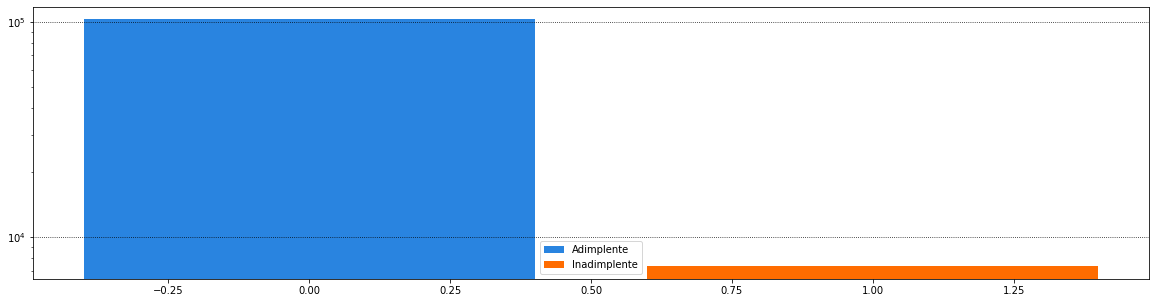

In [192]:
plot_bar(data_train, 'inadimplente')

2. util_linhas_inseguras
---

In [193]:
data_train.util_linhas_inseguras.value_counts()

0.000000    7983
1.000000    7585
1.000000      12
0.850299       5
0.954092       5
            ... 
0.156209       1
0.045194       1
0.122282       1
0.528319       1
0.037699       1
Name: util_linhas_inseguras, Length: 92671, dtype: int64

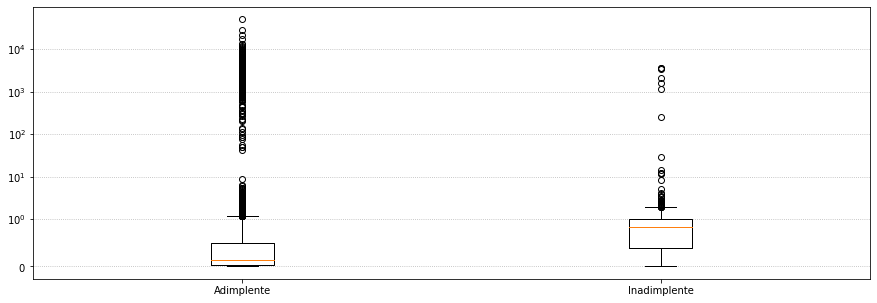

In [194]:
plot_box(data_train, 'util_linhas_inseguras')

3. idade
---

In [195]:
data_train.idade.value_counts()

48     2794
49     2788
46     2759
47     2718
50     2709
       ... 
103       2
107       1
105       1
0         1
109       1
Name: idade, Length: 86, dtype: int64

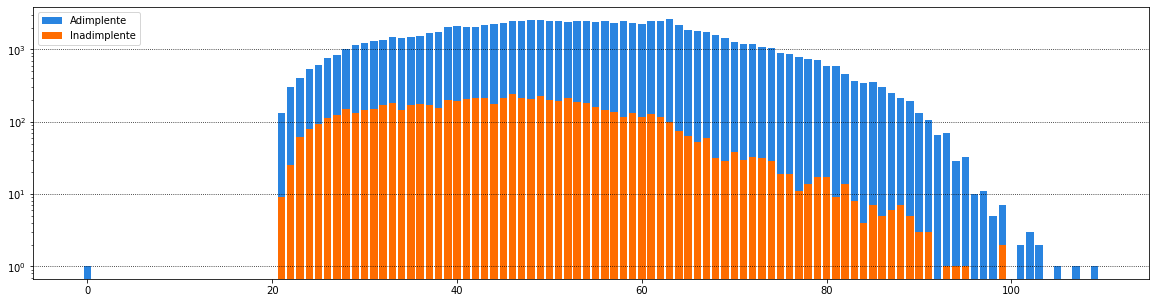

In [196]:
plot_bar(data_train, 'idade')

3. vezes_passou_de_30_59_dias
---

In [197]:
data_train.vezes_passou_de_30_59_dias.value_counts()

0     92469
1     11726
2      3343
3      1304
4       541
5       246
98      198
6        98
7        41
8        17
9         8
96        4
10        2
12        2
13        1
Name: vezes_passou_de_30_59_dias, dtype: int64

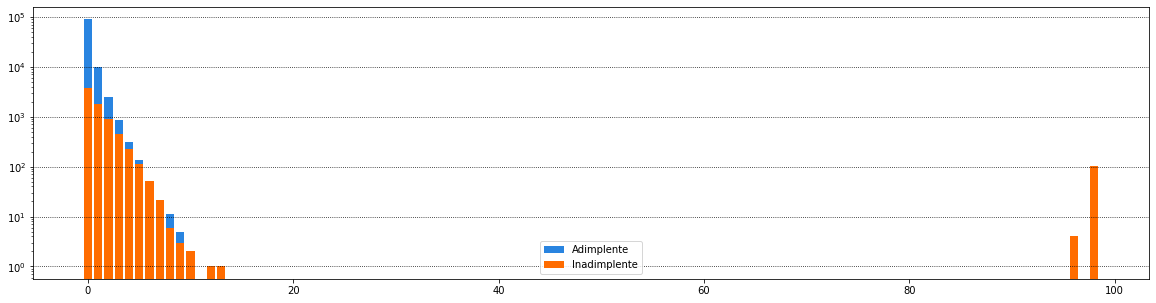

In [198]:
plot_bar(data_train, 'vezes_passou_de_30_59_dias')

4. razao_debito
---

In [199]:
data_train.razao_debito.value_counts()

0.000000    3030
1.000000     171
3.000000     130
4.000000     124
2.000000     114
            ... 
0.307381       1
0.460192       1
0.731127       1
0.310922       1
0.002352       1
Name: razao_debito, Length: 86002, dtype: int64

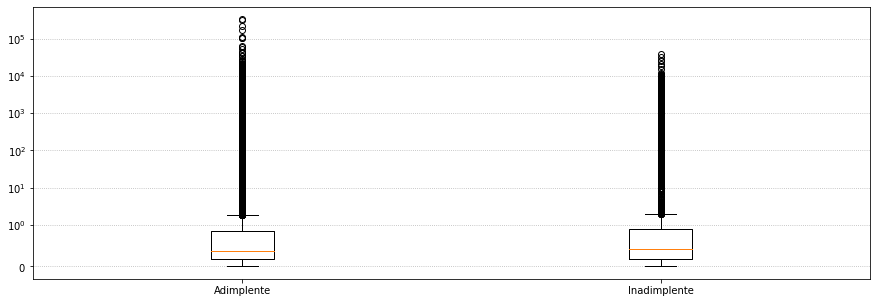

In [200]:
plot_box(data_train, 'razao_debito')

5. salario_mensal
---

In [201]:
data_train.salario_mensal.value_counts()

0.000000        8404
0.333333        5192
0.666667        2081
5000.000000     2038
4000.000000     1608
                ... 
6468.666667        1
14226.000000       1
16035.000000       1
394.000000         1
12224.000000       1
Name: salario_mensal, Length: 16136, dtype: int64

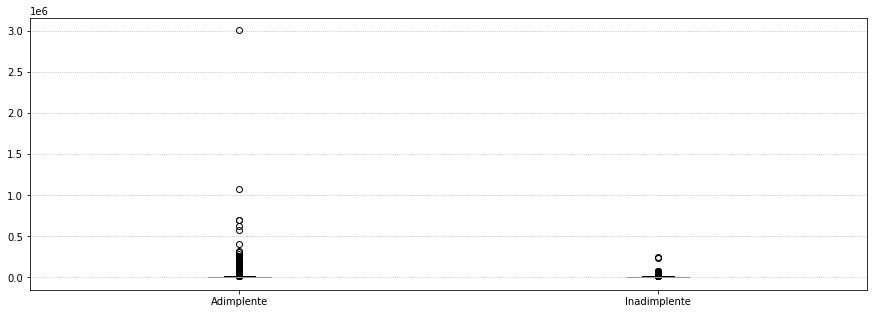

In [202]:
plot_box(data_train, 'salario_mensal', logscale=False)

6. numero_linhas_crdto_aberto
---

In [21]:
data_train.numero_linhas_crdto_aberto.value_counts()

6     9988
7     9675
5     9521
8     9171
4     8512
9     8240
10    7095
3     6652
11    6107
12    5122
2     4915
13    4163
14    3373
1     3252
15    2661
16    2173
17    1738
18    1428
0     1419
19    1037
20     847
21     649
22     522
23     394
24     313
25     221
26     164
27     138
28     111
29      91
30      62
31      58
32      37
33      31
34      21
36      17
35      13
38      11
40       8
37       5
45       5
48       5
54       4
43       4
42       4
39       3
46       3
41       3
56       2
49       2
52       2
51       2
44       2
58       1
57       1
47       1
50       1
Name: numero_linhas_crdto_aberto, dtype: int64

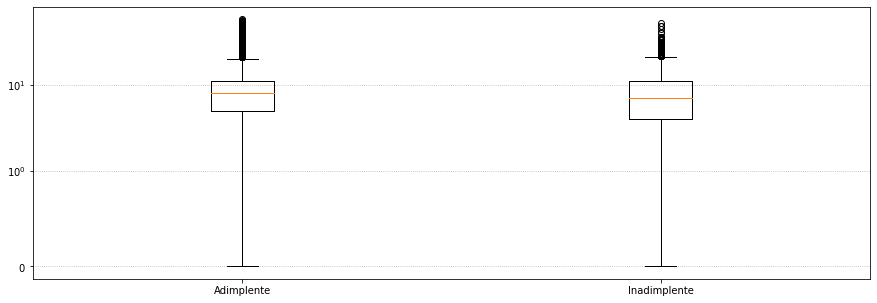

In [22]:
plot_box(data_train, 'numero_linhas_crdto_aberto')

7. numero_vezes_passou_90_dias
---

In [23]:
data_train.numero_vezes_passou_90_dias.value_counts()

0     103836
1       3886
2       1160
3        486
4        204
98       198
5        103
6         58
7         21
8         16
9         15
10         6
96         4
11         2
13         2
15         1
14         1
17         1
Name: numero_vezes_passou_90_dias, dtype: int64

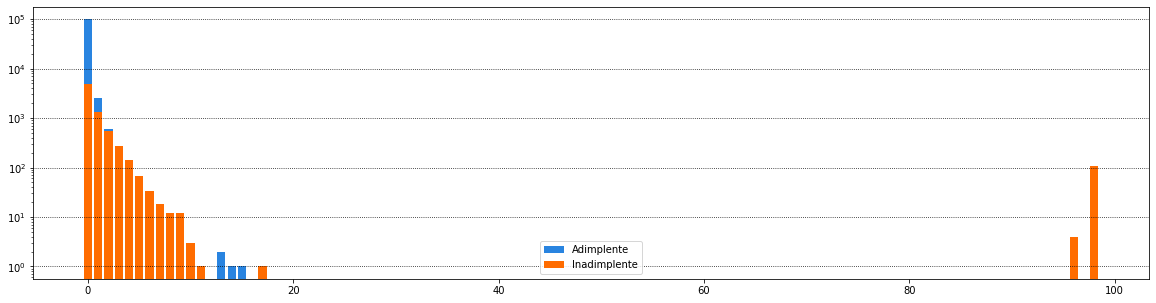

In [24]:
plot_bar(data_train, 'numero_vezes_passou_90_dias')

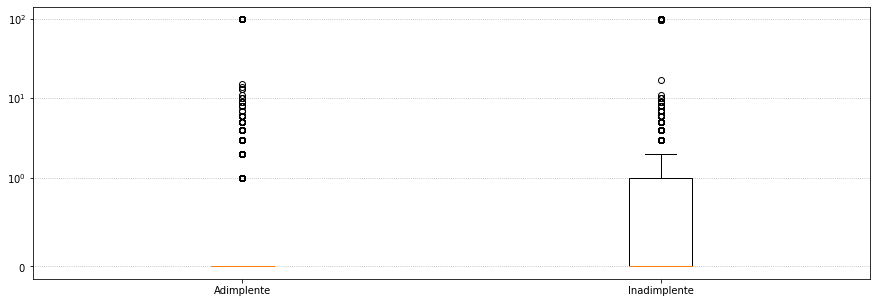

In [25]:
plot_box(data_train, 'numero_vezes_passou_90_dias')

8. numero_emprestimos_imobiliarios
---

In [26]:
data_train.numero_emprestimos_imobiliarios.value_counts()

0     41159
1     38354
2     23161
3      4644
4      1601
5       496
6       237
7       126
8        67
9        58
10       29
11       15
13       13
12       10
14        6
15        5
17        4
16        3
23        2
25        2
26        1
54        1
21        1
18        1
29        1
19        1
20        1
32        1
Name: numero_emprestimos_imobiliarios, dtype: int64

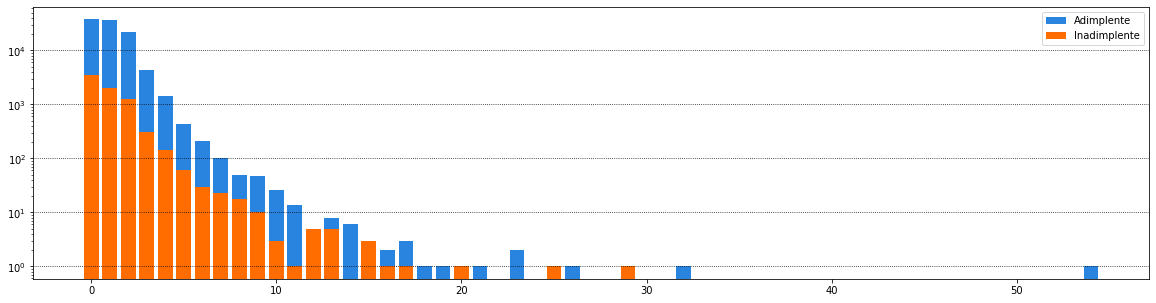

In [27]:
plot_bar(data_train, 'numero_emprestimos_imobiliarios')

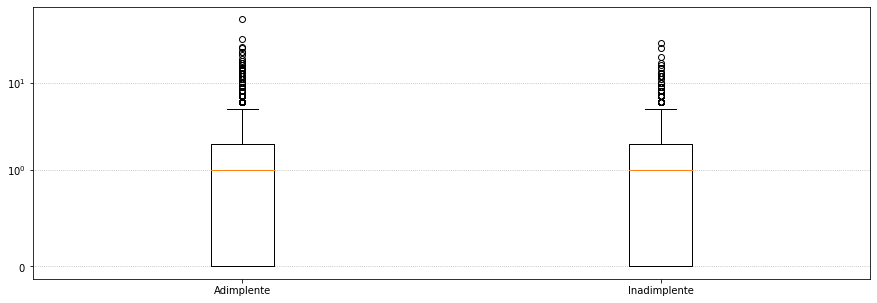

In [28]:
plot_box(data_train, 'numero_emprestimos_imobiliarios')

9. numero_de_vezes_que_passou_60_89_dias
---

In [29]:
data_train.numero_de_vezes_que_passou_60_89_dias.value_counts()

0     104466
1       4169
2        825
3        222
98       198
4         67
5         26
6         12
7          7
96         4
8          2
11         1
9          1
Name: numero_de_vezes_que_passou_60_89_dias, dtype: int64

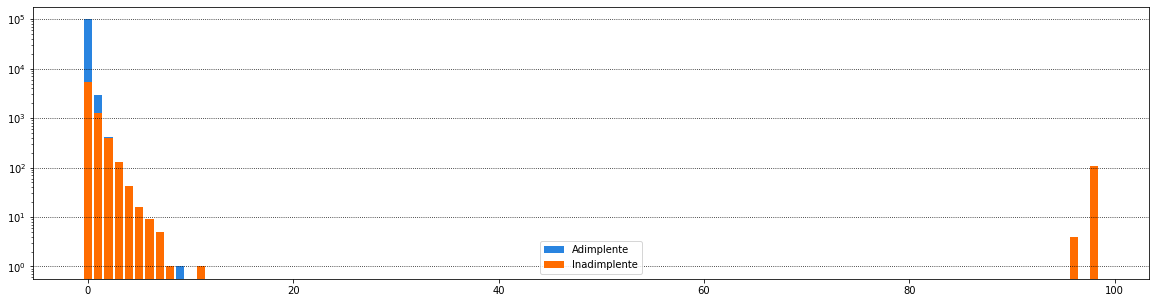

In [30]:
plot_bar(data_train, 'numero_de_vezes_que_passou_60_89_dias')

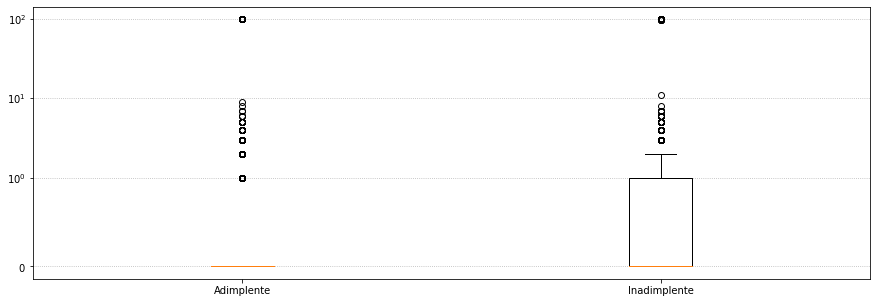

In [31]:
plot_box(data_train, 'numero_de_vezes_que_passou_60_89_dias')

10. numero_de_dependentes
---

In [203]:
data_train.numero_de_dependentes.value_counts()

0.0     66530
1.0     19416
2.0     14306
3.0      6898
4.0      2111
5.0       563
6.0       115
7.0        38
8.0        16
10.0        4
9.0         2
20.0        1
Name: numero_de_dependentes, dtype: int64

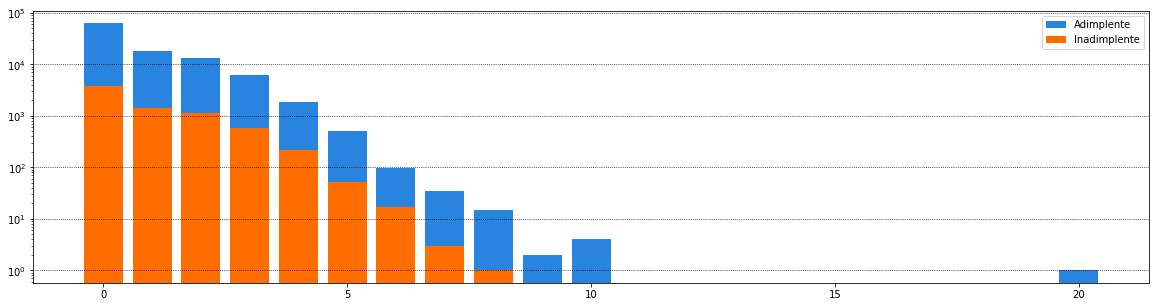

In [204]:
plot_bar(data_train, 'numero_de_dependentes')

---
## Matriz de Correlação
---

In [34]:
corr_matrix = data_train.corr()
corr_matrix

,cliente,inadimplente,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
cliente,1.000000,0.001944,0.002623,0.002049,0.000015,-0.002968,0.001255,0.005613,-0.000349,0.002563,-0.000087,-0.000810
inadimplente,0.001944,1.000000,-0.003263,-0.114281,0.124546,-0.006534,-0.020271,-0.029332,0.116023,-0.008144,0.101536,0.043079
util_linhas_inseguras,0.002623,-0.003263,1.000000,-0.004444,-0.001336,0.001255,0.008203,-0.010120,-0.001154,0.007590,-0.001105,-0.000986
idade,0.002049,-0.114281,-0.004444,1.000000,-0.063230,0.025221,0.040922,0.148640,-0.061371,0.032920,-0.057604,-0.212194
vezes_passou_de_30_59_dias,0.000015,0.124546,-0.001336,-0.063230,1.000000,-0.006860,-0.010939,-0.056347,0.984157,-0.031093,0.987377,-0.003183
razao_debito,-0.002968,-0.006534,0.001255,0.025221,-0.006860,1.000000,-0.033734,0.047158,-0.008344,0.117054,-0.007558,-0.042631
salario_mensal,0.001255,-0.020271,0.008203,0.040922,-0.010939,-0.033734,1.000000,0.096490,-0.013725,0.133508,-0.012404,0.066444
numero_linhas_crdto_aberto,0.005613,-0.029332,-0.010120,0.148640,-0.056347,0.047158,0.096490,1.000000,-0.080873,0.433337,-0.071979,0.065191
numero_vezes_passou_90_dias,-0.000349,0.116023,-0.001154,-0.061371,0.984157,-0.008344,-0.013725,-0.080873,1.000000,-0.045902,0.993162,-0.011052
numero_emprestimos_imobiliarios,0.002563,-0.008144,0.007590,0.032920,-0.031093,0.117054,0.133508,0.433337,-0.045902,1.000000,-0.039987,0.122481


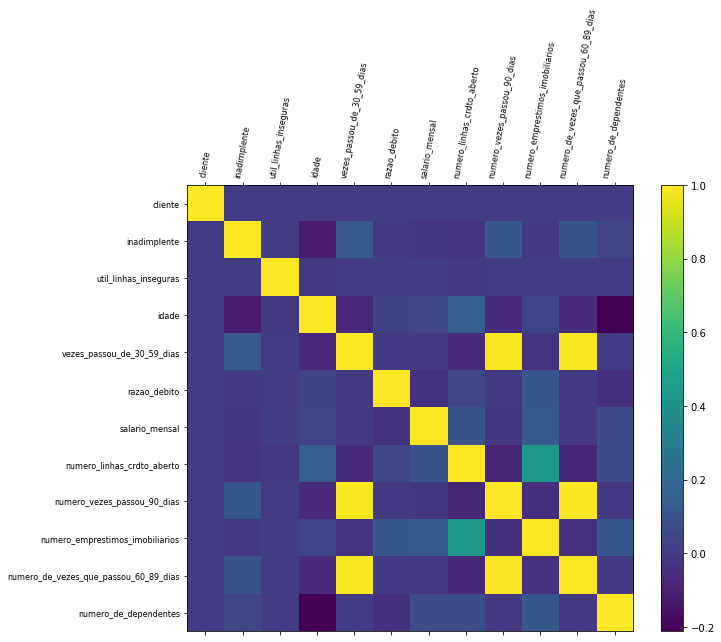

In [35]:
# melhor visualização
f = plt.figure(figsize=(10, 8))
plt.matshow(corr_matrix, fignum=f.number)
plt.xticks(range(data_train.shape[1]), data_train.columns, fontsize=8, rotation=80)
plt.yticks(range(data_train.shape[1]), data_train.columns, fontsize=8)
colorbar = plt.colorbar()
plt.show()

In [36]:
# verifica se há colunas com valor de correlação maior do que 0.8 em módulo
corr_aux = ((data_train.corr() > abs(0.8)) & (data_train.corr() != 1)).sum()

corr_aux[corr_aux > 0]

vezes_passou_de_30_59_dias               2
numero_vezes_passou_90_dias              2
numero_de_vezes_que_passou_60_89_dias    2
dtype: int64

In [37]:
# retorna as colunas e suas respectivas correlações em relação à coluna de entrada
def return_high_corr (feature):
    return corr_matrix.loc[feature][corr_matrix.loc[feature] > abs(0.8)]

In [38]:
return_high_corr('vezes_passou_de_30_59_dias')

vezes_passou_de_30_59_dias               1.000000
numero_vezes_passou_90_dias              0.984157
numero_de_vezes_que_passou_60_89_dias    0.987377
Name: vezes_passou_de_30_59_dias, dtype: float64

In [39]:
return_high_corr('numero_vezes_passou_90_dias')

vezes_passou_de_30_59_dias               0.984157
numero_vezes_passou_90_dias              1.000000
numero_de_vezes_que_passou_60_89_dias    0.993162
Name: numero_vezes_passou_90_dias, dtype: float64

In [40]:
return_high_corr('numero_de_vezes_que_passou_60_89_dias')

vezes_passou_de_30_59_dias               0.987377
numero_vezes_passou_90_dias              0.993162
numero_de_vezes_que_passou_60_89_dias    1.000000
Name: numero_de_vezes_que_passou_60_89_dias, dtype: float64

#### Sugestão de remoção devido à alta correlação:

In [41]:
drop_features = []
drop_features.extend(['numero_de_vezes_que_passou_60_89_dias', 'numero_vezes_passou_90_dias'])

---
## Testando Modelos
---

In [48]:
# remove as colunas desnecessárias
X_train = data_train.drop(columns=drop_features)
X_test = data_test.drop(columns=drop_features)

y_train = X_train.pop('inadimplente').astype('int')

In [49]:
random_state = 42

In [50]:
# primeiros modelos a serem analisados
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=random_state),
    "Random Forest": RandomForestClassifier(random_state=random_state),
    "Xgboost": xgb.XGBClassifier(random_state=random_state, use_label_encoder=False),
    "Lightgbm": lgb.LGBMClassifier(random_state=random_state)
}

# métricas que serão avaliadas
scores = {
    "recall": "recall",
    "precision": "precision",
    "f1": "f1",
    "accuracy": "balanced_accuracy",
}

In [51]:
# resultado das métricas, para cada modelo
dic_metrics = {}

for model_name, model in models.items():
    clf = model
    if model_name == 'Xgboost':
        clf.fit(X_train, y_train, eval_metric='logloss')
    else:
        clf.fit(X_train, y_train)
    resultados = cross_validate(model, X_train, y_train, scoring=scores, cv=5)
    dic_metrics[model_name] = resultados

[23:43:35] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1643226942235/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/laryssastephanie/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[23:43:40] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1643226942235/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:43:48] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1643226942235/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:43:54] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1643226942235/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:44:00] WARNING: /home

/home/laryssastephanie/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:
# mostra as métricas em um dataframe
pd.set_option('display.max_columns', None)
metrics = pd.DataFrame.from_dict(dic_metrics, orient="index").stack().to_frame()
metrics = pd.DataFrame(metrics[0].values.tolist(), index=metrics.index)
metrics['Media'] = metrics.mean(axis=1)
metrics['Desvio'] = metrics.std(axis=1)
metrics = metrics.transpose()
metrics

Decision Tree                                                  \
            fit_time score_time test_recall test_precision   test_f1   
0           0.807135   0.032617    0.254942       0.195300  0.221171   
1           0.789685   0.026918    0.266712       0.073579  0.115339   
2           0.837080   0.028073    0.224420       0.193529  0.207833   
3           0.782822   0.024331    0.196453       0.202960  0.199653   
4           0.834609   0.022997    0.700546       0.052040  0.096882   
Media       0.810266   0.026987    0.328615       0.143482  0.168176   
Desvio      0.022352   0.003342    0.187572       0.066296  0.051471   

                     Random Forest                                        \
       test_accuracy      fit_time score_time test_recall test_precision   
0           0.589946     14.342194   0.312226    0.041581       0.616162   
1           0.513482     14.420071   0.360269    0.091405       0.501873   
2           0.578826     14.396699   0.361001    0.082538       0.489879   
3           0.570687     14.578001   0.388516    0.083220       0.532751   
4           0.394736     14.870416   0.180193    0.983629       0.066464   
Media       0.529535     14.521476   0.320441    0.256475       0.441426   
Desvio      0.072389      0.191285   0.074300    0.363992       0.192598   

                                 Xgboost                         \
         test_f1 test_accuracy  fit_time score_time test_recall   
0       0.077905      0.519865  5.624606   0.051872    0.000000   
1       0.154645      0.542464  7.609381   0.053197    0.693042   
2       0.141273      0.538201  6.239556   0.052010    0.278308   
3       0.143953      0.539004  5.797950   0.047449    0.019100   
4       0.124514      0.498632  5.977778   0.054668    0.978854   
Media   0.128458      0.527633  6.249854   0.051839    0.393861   
Desvio  0.027060      0.016506  0.709591   0.002415    0.384877   

                                               Lightgbm             \
       test_precision   test_f1 test_accuracy  fit_time score_time   
0            0.000000  0.000000      0.500000  0.561852   0.055402   
1            0.130440  0.219557      0.681600  0.693828   0.056887   
2            0.266145  0.272091      0.611761  0.789076   0.067610   
3            0.583333  0.036988      0.509063  0.548688   0.063763   
4            0.081618  0.150672      0.596250  0.541484   0.060401   
Media        0.212307  0.135862      0.579735  0.626986   0.060813   
Desvio       0.204653  0.103939      0.067863  0.098412   0.004467   

                                                           
       test_recall test_precision   test_f1 test_accuracy  
0         0.000000       0.000000  0.000000      0.500000  
1         0.113915       0.501502  0.185659      0.552916  
2         0.077763       0.545455  0.136119      0.536568  
3         0.052524       0.570370  0.096190      0.524850  
4         0.238063       0.379348  0.292540      0.605128  
Media     0.096453       0.399335  0.142102      0.543892  
Desvio    0.079926       0.210195  0.096815      0.035140

___
## Treino com Grid Search randomizado: Random Forest
___

In [53]:
rf = RandomForestClassifier(n_jobs=-1, random_state=random_state)

# parâmetros a serem analisados
params = {
    'max_depth': sp.stats.uniform(loc=5, scale=10),
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', 'log2']
}

rf_gs = RandomizedSearchCV(rf, params, n_iter=10, cv=5, scoring='f1', random_state=random_state, error_score='raise')

rf_gs.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa1dc436550>,
                                        'max_features': ['auto', 'log2']},
                   random_state=42, scoring='f1')

In [54]:
# média dos 5 folds de cross-validation
rf_gs.cv_results_['mean_test_score'].mean()

0.09522667785017662

In [55]:
# desvio padrão dos 5 folds de cross-validation
rf_gs.cv_results_['std_test_score'].mean()

0.06532300668662953

In [56]:
# relatório dos resultados
print(classification_report(y_train, rf_gs.predict(X_train)))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97    102669
           1       0.99      0.22      0.36      7331

    accuracy                           0.95    110000
   macro avg       0.97      0.61      0.67    110000
weighted avg       0.95      0.95      0.93    110000



___
## Treino com Grid Search randomizado: LightGBM
___

In [57]:
lgbm = lgb.LGBMClassifier(n_jobs=-1, objective='binary', random_state=random_state)

# parâmetros a serem analisados
params = {
    'max_depth': [5, 10, 15],
    'reg_lambda': sp.stats.uniform(loc=0, scale=2),
    'learning_rate': sp.stats.uniform(loc=.05, scale=0.15),
    'min_split_gain': sp.stats.uniform(loc=0, scale=5),
    'subsample': sp.stats.uniform(loc=0, scale=1)
}

lgbm_gs = RandomizedSearchCV(lgbm, params, n_iter=10, cv=5, scoring='f1', random_state=random_state, error_score='raise')

lgbm_gs.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=LGBMClassifier(objective='binary',
                                            random_state=42),
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa1dc47e400>,
                                        'max_depth': [5, 10, 15],
                                        'min_split_gain': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa1dc4e2ee0>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa1dc4e2d00>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa1dc700550>},
                   random_state=42, scoring='f1')

In [58]:
# média dos 5 folds de cross-validation
lgbm_gs.cv_results_['mean_test_score'].mean()

0.15235760818627658

In [59]:
# desvio padrão dos 5 folds de cross-validation
lgbm_gs.cv_results_['std_test_score'].mean()

0.10932944238748214

In [60]:
# relatório dos resultados
print(classification_report(y_train, lgbm_gs.predict(X_train)))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97    102669
           1       0.72      0.13      0.22      7331

    accuracy                           0.94    110000
   macro avg       0.83      0.56      0.59    110000
weighted avg       0.93      0.94      0.92    110000



___
## Treino com Grid Search randomizado: XGBoost
___

In [61]:
xgb = xgb.XGBClassifier(n_jobs=-1, use_label_encoder=False, random_state=random_state)

# parâmetros a serem analisados
params = {
    'max_depth': [5, 10, 15],
    'reg_lambda': sp.stats.uniform(loc=0, scale=2),
    'learning_rate': sp.stats.uniform(loc=.05, scale=0.15),
    'min_child_weight': sp.stats.uniform(loc=0.01, scale=2.99),
    'subsample': sp.stats.uniform(loc=0, scale=1)
}

xgb_gs = RandomizedSearchCV(xgb, params, n_iter=10, cv=5, scoring='f1', random_state=random_state, error_score='raise')

xgb_gs.fit(X_train, y_train, eval_metric='logloss')

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,...
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa1dc50cdf0>,
                                        'max_depth': [5, 10, 15],
                             

In [62]:
# média dos 5 folds de cross-validation
xgb_gs.cv_results_['mean_test_score'].mean()

0.16872191033502482

In [63]:
# desvio padrão dos 5 folds de cross-validation
xgb_gs.cv_results_['std_test_score'].mean()

0.10433009448337778

In [64]:
# relatório dos resultados
print(classification_report(y_train, xgb_gs.predict(X_train)))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97    102669
           1       0.63      0.13      0.22      7331

    accuracy                           0.94    110000
   macro avg       0.79      0.56      0.59    110000
weighted avg       0.92      0.94      0.92    110000



___
## Comparação das métricas
___

In [65]:
# modelos treinados
trained_models = {
    'RandForest': rf_gs,
    'LightGBM': lgbm_gs,
    'XGBoost': xgb_gs
}

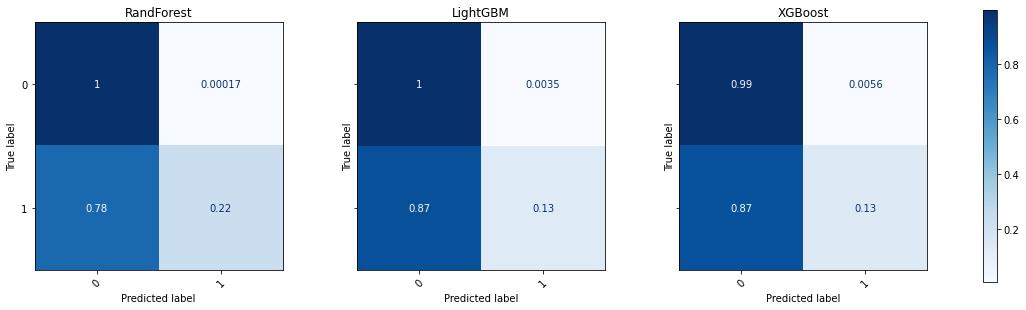

In [175]:
# plot das matrizes de confusão
f, axes = plt.subplots(1, 3, figsize=(20, 5), sharey='row')

i = 0
for model_name, model in trained_models.items():
    disp = ConfusionMatrixDisplay(confusion_matrix(y_train, model.predict(X_train), normalize='true'), display_labels=[0, 1])
    disp.plot(ax=axes[i], xticks_rotation=45, cmap='Blues')
    disp.ax_.set_title(model_name)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('Predicted label')
    disp.ax_.set_ylabel('True label')
    i += 1

plt.subplots_adjust(wspace=.3, hspace=.1)

f.colorbar(disp.im_, ax=axes)
plt.show()

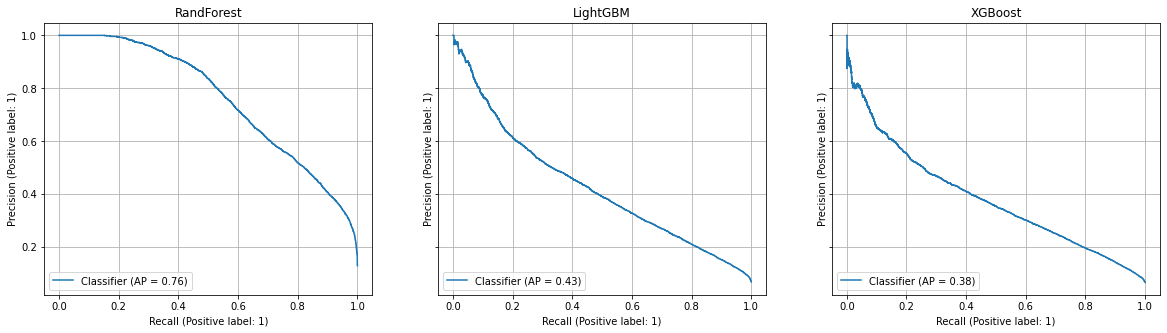

In [67]:
# plot das curvas de recall-precision
f, axes = plt.subplots(1, 3, figsize=(20, 5), sharey='row')

i = 0
for model_name, model in trained_models.items():
    disp = PrecisionRecallDisplay.from_predictions(y_train, model.predict_proba(X_train)[:,1], ax=axes[i])
    disp.ax_.set_title(model_name)
    axes[i].grid()
    i += 1

plt.show()

O modelo que se mostrou com melhor curva de precision-recall foi o Random Forest, portanto seguiremos com ele para a etapa final

---
## Seguindo com _Random Forest_ para etapa final

Ajustando os Thresholds

---

In [69]:
# listas com as precisions, recalls e thresholds para vários pontos da curva (pega apenas a coluna 1 do resultado da função -> probabilidades para classe 1)
precision, recall, threshold = precision_recall_curve(y_train, rf_gs.predict_proba(X_train)[:,1])
# adiciona um NaN apenas para que fique do mesmo tamanho que as outras listas
threshold = np.append(threshold, np.nan)

In [141]:
""" analisando os dados acima em um dataframe e pegando os threshold que geram no mínimo
um recall de 80% (valores podem ser alterados de acordo com a "necessidade de mais acerto" do modelo)"""
rf_prc = pd.DataFrame({'Precision': precision.T, 
                        'Recall': recall.T, 
                        'Threshold': threshold.T
                        }).query('Recall >= .8')
rf_prc

,Precision,Recall,Threshold
0,0.130218,1.000000,0.020822
1,0.130202,0.999864,0.020823
2,0.130205,0.999864,0.020823
3,0.130207,0.999864,0.020823
4,0.130209,0.999864,0.020823
...,...,...,...
44982,0.518656,0.800164,0.178217
44983,0.518702,0.800164,0.178220
44984,0.518748,0.800164,0.178221
44985,0.518794,0.800164,0.178245


In [142]:
final_model_rf = rf_gs.best_estimator_

In [149]:
rf_ajustado = Thresholder(final_model_rf, 0.178256) # Threshold com Precision de 51.87% e Recall de 80%
rf_ajustado.fit(X_train, y_train)

Thresholder(model=RandomForestClassifier(criterion='entropy',
                                         max_depth=14.385527090157503,
                                         max_features='log2', n_jobs=-1,
                                         random_state=42),
            threshold=0.178256)

/home/laryssastephanie/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


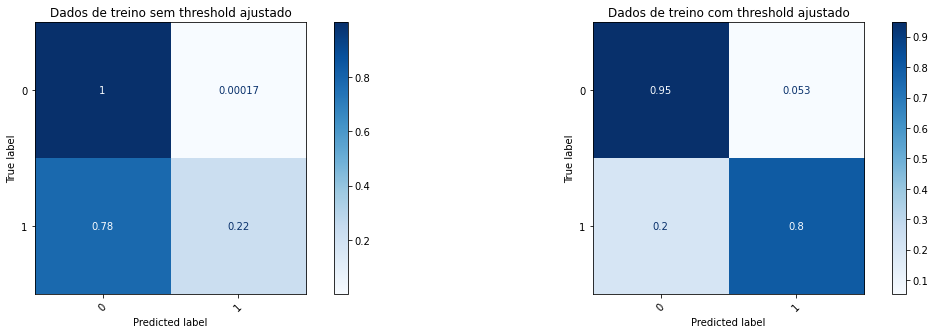

In [174]:
# plot matriz confusão - dados de treino
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

disp11 = ConfusionMatrixDisplay(confusion_matrix(y_train, rf_gs.predict(X_train), normalize='true'), display_labels=[0, 1])
disp11.plot(ax=ax[0], xticks_rotation=45, cmap='Blues')
disp11.ax_.set_title('Dados de treino sem threshold ajustado')
disp12 = ConfusionMatrixDisplay(confusion_matrix(y_train, rf_ajustado.predict(X_train), normalize='true'), display_labels=[0, 1])
disp12.plot(ax=ax[1], xticks_rotation=45, cmap='Blues')
disp12.ax_.set_title('Dados de treino com threshold ajustado')
plt.subplots_adjust(wspace=0)

plt.show()

___
## Testando o modelo
---

In [129]:
data_test.insert(1, 'sera_inadimplente', rf_ajustado.predict(X_test))

/home/laryssastephanie/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [130]:
data_test

,cliente,sera_inadimplente,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
0,1,0,0.025849,62,0,0.081775,8180.0,3,0,2,0,0.0
1,2,0,0.667083,55,0,0.153112,2200.0,3,0,0,0,0.0
2,3,0,0.007093,44,0,0.148800,7499.0,20,0,1,0,0.0
3,4,0,0.091213,54,0,0.351635,5900.0,15,0,1,1,0.0
4,5,0,0.112680,54,0,0.065959,2167.0,3,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
39995,39996,0,0.000000,68,1,0.062858,10833.0,9,1,0,0,0.0
39996,39997,0,0.061117,84,0,0.013598,8456.0,7,0,0,0,0.0
39997,39998,0,0.817745,70,0,0.663056,6000.0,17,0,2,0,0.0
39998,39999,0,0.106139,64,2,0.865438,5045.0,12,0,4,0,0.0


In [131]:
data_test['sera_inadimplente'].value_counts()

0    35792
1     4208
Name: sera_inadimplente, dtype: int64

In [151]:
# print de informações
qtd_total_test = data_test.shape[0]
inadimplentes_test = sum(data_test['sera_inadimplente'])
adimplentes_test = qtd_total_test - inadimplentes_test

print("Teste:")
print(f"{inadimplentes_test} usuarios possivelmente inadimplentes -> {inadimplentes_test/qtd_total_test * 100:3.2f}% dos dados totais")
print(f"{adimplentes_test} usuarios possivelmente adimplentes -> {adimplentes_test/qtd_total_test * 100:3.2f}% dos dados totais\n")

Teste:
4208 usuarios possivelmente inadimplentes -> 10.52% dos dados totais
35792 usuarios possivelmente adimplentes -> 89.48% dos dados totais



In [154]:
data_test.to_csv('case_datarisk/predito.csv', index=False)

In [77]:
# Exportando o modelo em Pickle
# Descomentar as linhas abaixo para salvar o modelo

# output = open('modelo_rf', 'wb')
# pickle.dump(adj_th_rf, output)
# output.close()